In [1]:
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
from scipy.integrate import trapz

# Import Data

In [2]:
%store -r acc_dict
person_names = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18"]

In [3]:
features = pd.read_excel('features.xlsx')
start = np.array(features['from_imu']).astype(int)
end = np.array(features['to_imu']).astype(int)
exploratory = np.array(features['exploratory'])
performance = np.array(features['performance'])
double = np.array(features['double'])

section_dict = {}
for i, person_name in enumerate(person_names):
    acc_dataset = acc_dict[person_name]
    total_time = acc_dataset['time']

    acc_dataset['grasping_exploratory'] = exploratory[i]
    acc_dataset['grasping_performance'] = performance[i]
    acc_dataset['grasping_double'] = double[i]
    section_dict[person_name] = {'start': start[i], 'end': end[i], 'time_1': np.arange(1, start[i]), 'time_2': np.arange(start[i], end[i]), 'time_3': np.arange(end[i], len(total_time) - 1)}

# Section Extraction
Section 1 - 3 for all axes and the vector of the jerk value

In [4]:
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    start = section_dict[person_name]['start']
    end = section_dict[person_name]['end']

    acc_dataset['section_1_x_jerk_normalized_global'] = acc_dataset['acc_x_derivative_normalized_global'][0:start]
    acc_dataset['section_2_x_jerk_normalized_global'] = acc_dataset['acc_x_derivative_normalized_global'][start:end]
    acc_dataset['section_3_x_jerk_normalized_global'] = acc_dataset['acc_x_derivative_normalized_global'][end:-1]
    acc_dataset['section_1_y_jerk_normalized_global'] = acc_dataset['acc_y_derivative_normalized_global'][0:start]
    acc_dataset['section_2_y_jerk_normalized_global'] = acc_dataset['acc_y_derivative_normalized_global'][start:end]
    acc_dataset['section_3_y_jerk_normalized_global'] = acc_dataset['acc_y_derivative_normalized_global'][end:-1]
    acc_dataset['section_1_z_jerk_normalized_global'] = acc_dataset['acc_z_derivative_normalized_global'][0:start]
    acc_dataset['section_2_z_jerk_normalized_global'] = acc_dataset['acc_z_derivative_normalized_global'][start:end]
    acc_dataset['section_3_z_jerk_normalized_global'] = acc_dataset['acc_z_derivative_normalized_global'][end:-1]
    acc_dataset['section_1_vector_jerk_normalized_global'] = acc_dataset['jerk_vector_normalized_global'][0:start]
    acc_dataset['section_2_vector_jerk_normalized_global'] = acc_dataset['jerk_vector_normalized_global'][start:end]
    acc_dataset['section_3_vector_jerk_normalized_global'] = acc_dataset['jerk_vector_normalized_global'][end:-1]


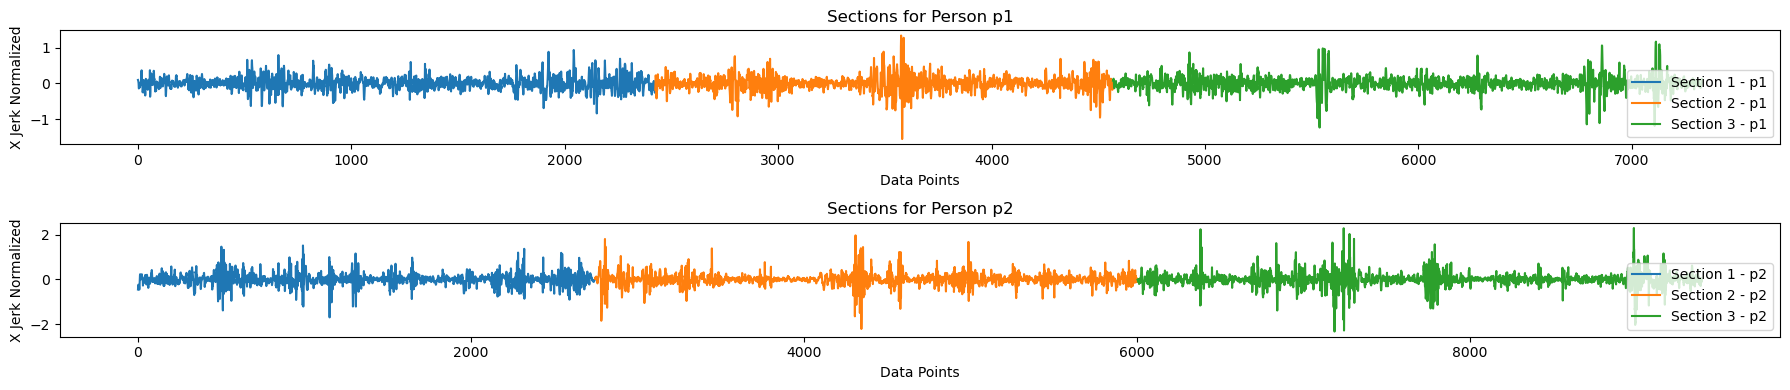

In [5]:
# Extract the data for person p1
p1_section1 = acc_dict['p1']['section_1_x_jerk_normalized_global']
p1_section2 = acc_dict['p1']['section_2_x_jerk_normalized_global']
p1_section3 = acc_dict['p1']['section_3_x_jerk_normalized_global']

# Extract the data for person p2
p2_section1 = acc_dict['p2']['section_1_x_jerk_normalized_global']
p2_section2 = acc_dict['p2']['section_2_x_jerk_normalized_global']
p2_section3 = acc_dict['p2']['section_3_x_jerk_normalized_global']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))

# Plot data for person p1
ax1.plot(p1_section1, label='Section 1 - p1')
ax1.plot(p1_section2, label='Section 2 - p1')
ax1.plot(p1_section3, label='Section 3 - p1')
ax1.set_title('Sections for Person p1')
ax1.set_xlabel('Data Points')
ax1.set_ylabel('X Jerk Normalized')
ax1.legend()

# Plot data for person p2
ax2.plot(p2_section1, label='Section 1 - p2')
ax2.plot(p2_section2, label='Section 2 - p2')
ax2.plot(p2_section3, label='Section 3 - p2')
ax2.set_title('Sections for Person p2')
ax2.set_xlabel('Data Points')
ax2.set_ylabel('X Jerk Normalized')
ax2.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Mean Squared Jerk
Computation for all axes and the vector for all sections

In [6]:
jerk_values = {'section_1_x': {}, 'section_1_y': {}, 'section_1_z': {}, 'section_1_vector': {}, 'section_2_x': {}, 'section_2_y': {}, 'section_2_z': {}, 'section_2_vector': {}, 'section_3_x': {}, 'section_3_y': {}, 'section_3_z': {}, 'section_3_vector': {}}

for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    section_dataset = section_dict[person_name]
    time = acc_dataset['time']
    time_1 = section_dataset['time_1']
    time_2 = section_dataset['time_2']
    time_3 = section_dataset['time_3']
    start_section_2 = len(time_1) + 1
    start_section_3 = len(time_1) + len(time_2) + 1
    
    for axis in ['x', 'y', 'z', 'vector']:
        section1 = acc_dataset[f'section_1_{axis}_jerk_normalized_global'][0:len(time_1)]
        section2 = acc_dataset[f'section_2_{axis}_jerk_normalized_global'][start_section_2  : start_section_3]
        section3 = acc_dataset[f'section_3_{axis}_jerk_normalized_global'][start_section_3 : len(time_1) + len(time_2) + len(time_3) + 1]
        
        # Integrate 
        integral_value_1 = trapz(np.abs(section1), time_1)
        integral_value_2 = trapz(np.abs(section2), time_2)
        integral_value_3 = trapz(np.abs(section3), time_3)
        mean_jerk_1 = (1 / len(time_1)) * integral_value_1
        mean_jerk_2 = (1 / len(time_2)) * integral_value_2
        mean_jerk_3 = (1 / len(time_3)) * integral_value_3

        jerk_values[f'section_1_{axis}'][person_name] = mean_jerk_1
        jerk_values[f'section_2_{axis}'][person_name] = mean_jerk_2
        jerk_values[f'section_3_{axis}'][person_name] = mean_jerk_3

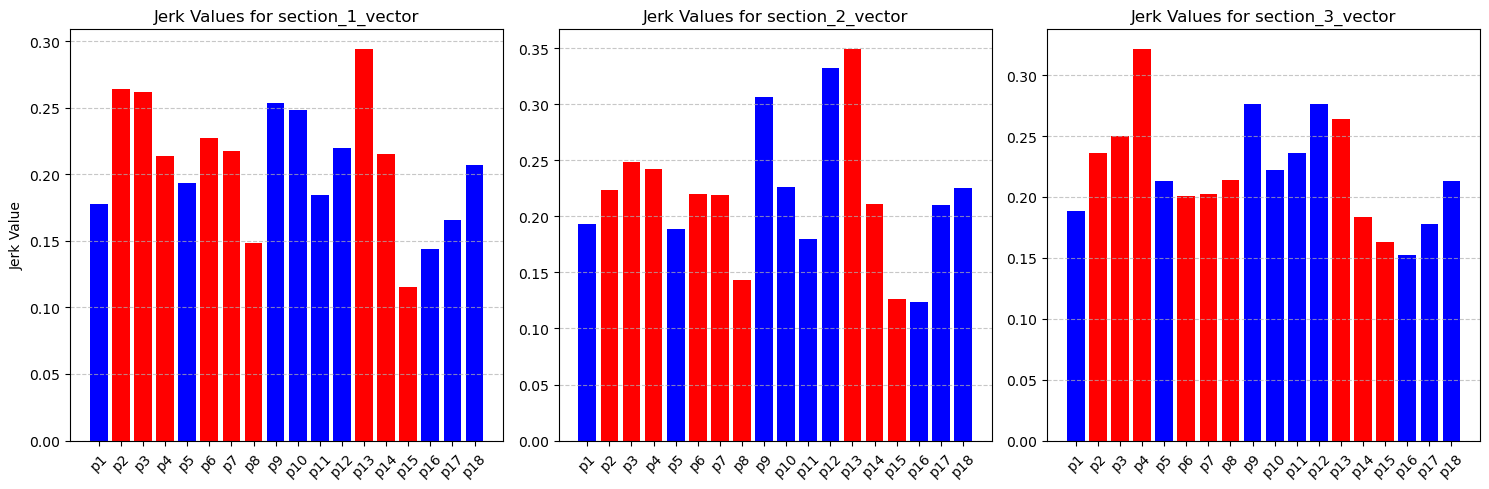

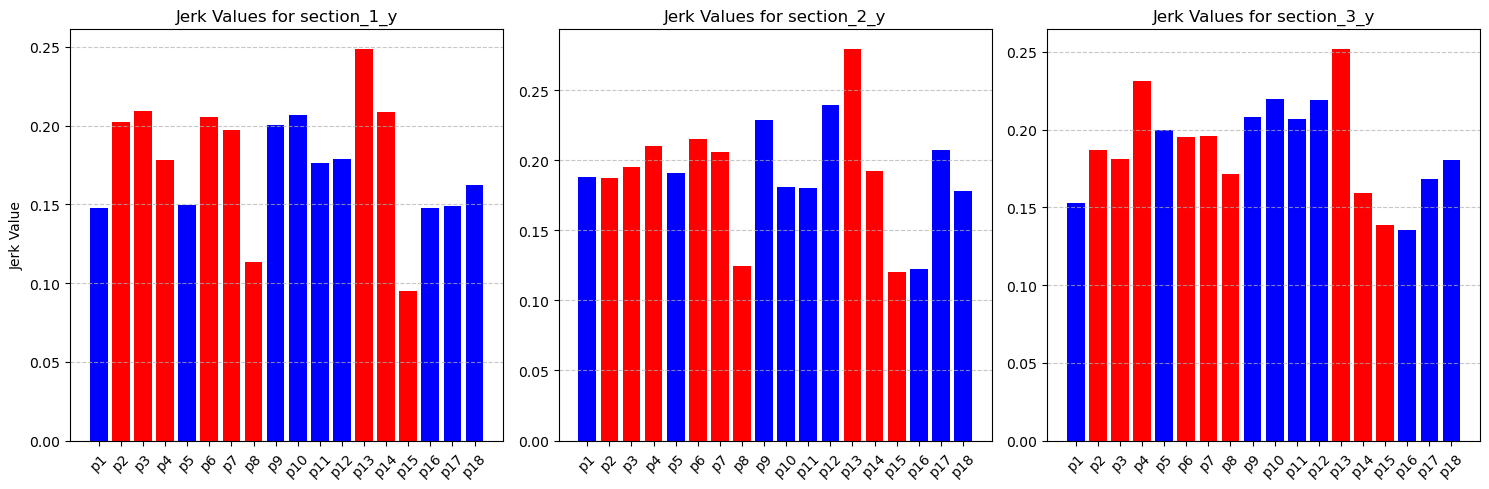

In [7]:
axes = ['section_1_vector', 'section_2_vector', 'section_3_vector']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, axis in enumerate(axes):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    
    # Plot the integrated values with colors
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

axs[0].set_ylabel('Jerk Value')
plt.tight_layout()
plt.show()

axes_x = ['section_1_y', 'section_2_y', 'section_3_y']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, axis in enumerate(axes_x):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    
    # Plot the integrated values with colors
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

axs[0].set_ylabel('Jerk Value')
plt.tight_layout()
plt.show()

# Feature Grasping

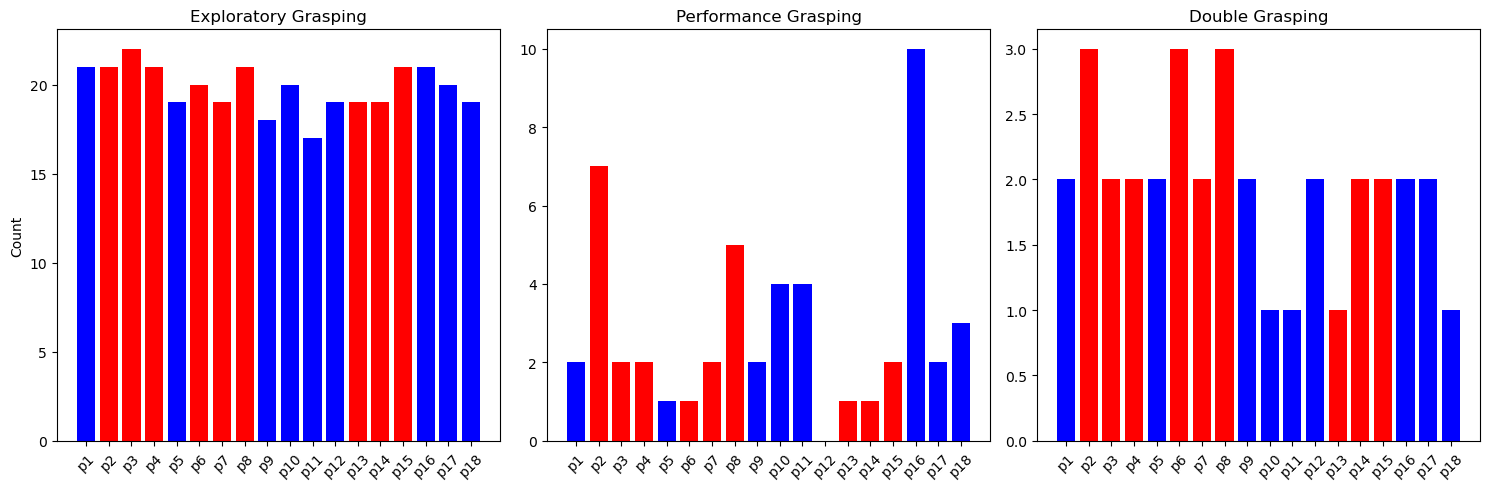

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your data and defined your variables

# Initialize the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting for each grasping type
for i, grasping_type in enumerate(['grasping_exploratory', 'grasping_performance', 'grasping_double']):
    # Getting the data and gender for the current grasping type for all persons
    grasping_values = [acc_dict[person_name][grasping_type] for person_name in person_names]
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Plotting the data in the current subplot
    ax = axes[i]
    for person_name, grasping_value, gender in zip(person_names, grasping_values, genders):
        color = 'blue' if gender == 'male' else 'red'
        ax.bar(person_name, grasping_value, color=color)
    
    # Setting titles and labels
    ax.set_title(f'{grasping_type.split("_")[1].capitalize()} Grasping')
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel('Count')
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [9]:
jerk_values_women = {'section_1_x': [], 'section_1_y': [], 'section_1_z': [], 'section_1_vector': [], 'section_2_x': [], 'section_2_y': [], 'section_2_z': [], 'section_2_vector': [], 'section_3_x': [], 'section_3_y': [], 'section_3_z': [], 'section_3_vector': []}
jerk_values_men = {'section_1_x': [], 'section_1_y': [], 'section_1_z': [], 'section_1_vector': [], 'section_2_x': [], 'section_2_y': [], 'section_2_z': [], 'section_2_vector': [], 'section_3_x': [], 'section_3_y': [], 'section_3_z': [], 'section_3_vector': []}

for axis, values in jerk_values.items():
    person_names = list(values.keys())
    values = list(values.values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    for person_name, jerk_value, gender in zip(person_names, values, genders):
        if gender == 'female':
            jerk_values_women[axis].append(jerk_value)
        elif gender == 'male':
            jerk_values_men[axis].append(jerk_value)

mean_jerk_values_women = {axis: np.mean(values) for axis, values in jerk_values_women.items()}
std_jerk_values_women = {axis: np.std(values) for axis, values in jerk_values_women.items()}
mean_jerk_values_men = {axis: np.mean(values) for axis, values in jerk_values_men.items()}
std_jerk_values_men = {axis: np.std(values) for axis, values in jerk_values_men.items()}

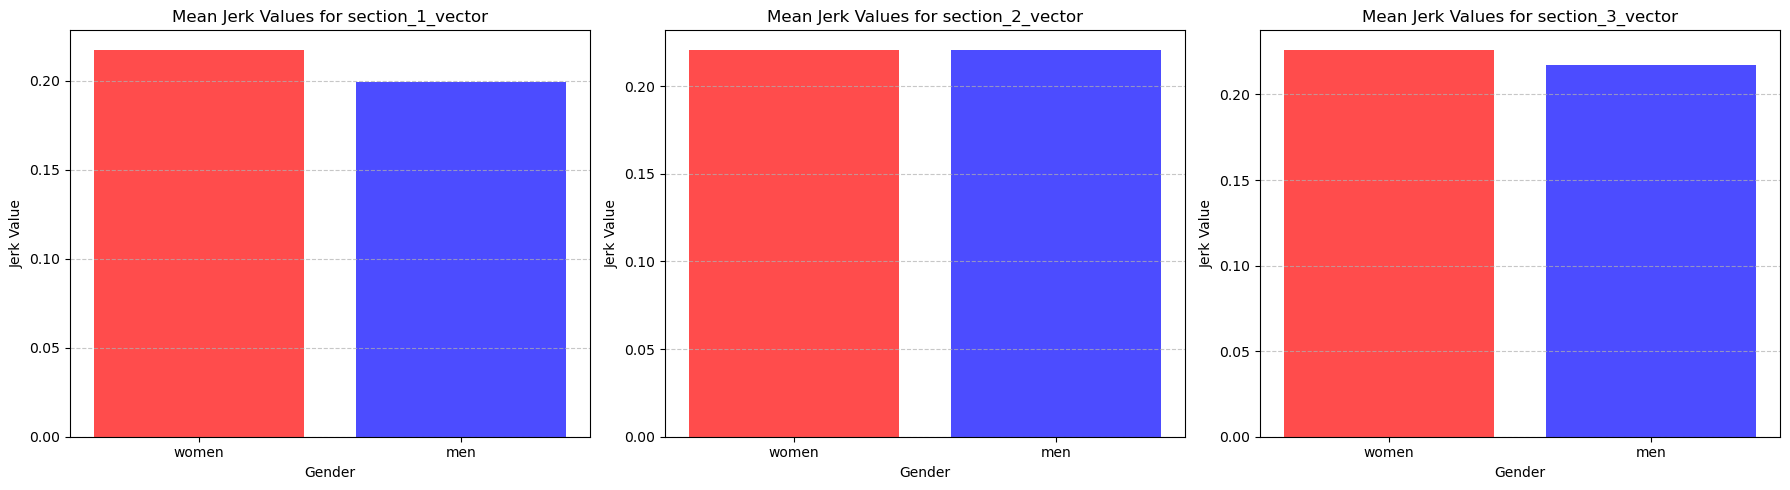

In [10]:
axes = ['section_1_vector', 'section_2_vector', 'section_3_vector']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, axis in enumerate(axes):
    x_labels = ['women', 'men']
    
    # Define the x positions for bars
    x = range(len(x_labels))
    
    # Define the y-axis values for mean and std for women and men
    y_mean_values = [mean_jerk_values_women[axis], mean_jerk_values_men[axis]]
    y_std_values = [std_jerk_values_women[axis], std_jerk_values_men[axis]]
    
    # Define the colors for women and men
    colors = ['red', 'blue']
    
    # Plot the bar plot for mean values
    axs[i].bar(x, y_mean_values, color=colors, alpha=0.7, capsize=5)
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(x_labels)
    axs[i].set_xlabel('Gender')
    axs[i].set_ylabel('Jerk Value')
    axs[i].set_title(f'Mean Jerk Values for {axis}')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

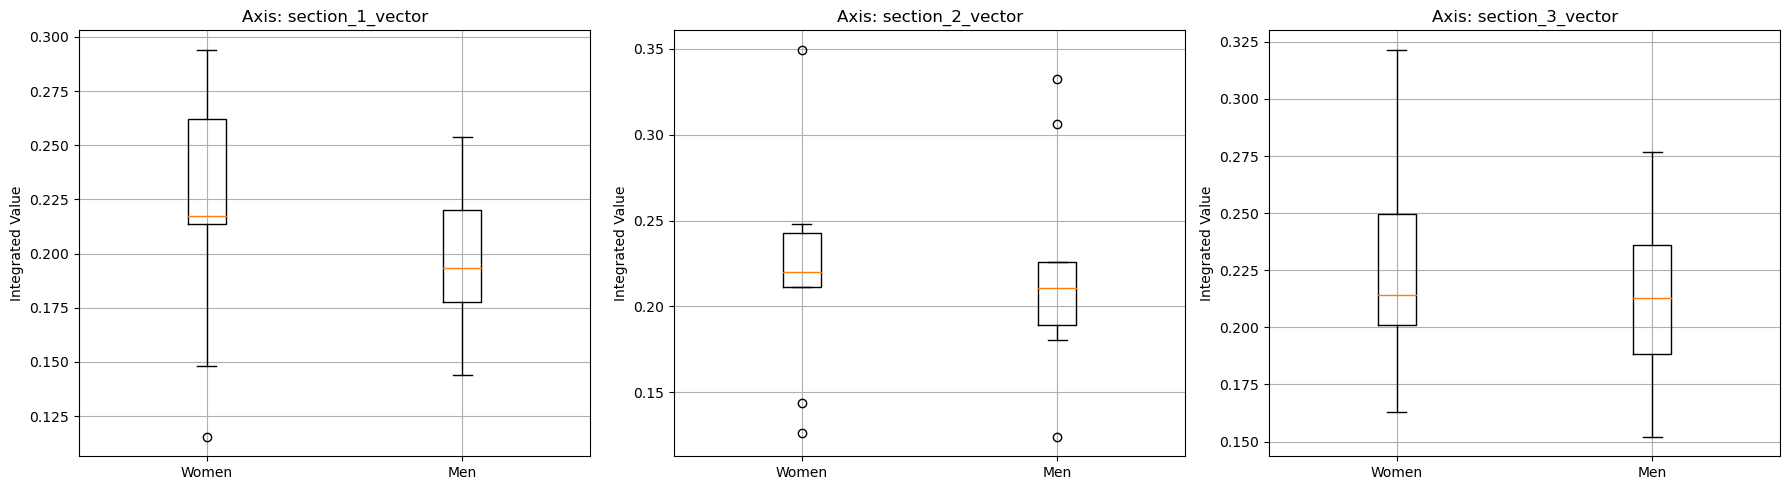

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, axis in enumerate(['section_1_vector', 'section_2_vector', 'section_3_vector']):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Separate integrated values for women and men
    plot_jerk_values_women = [values[j] for j, gender in enumerate(genders) if gender == 'female']
    plot_jerk_values_men = [values[j] for j, gender in enumerate(genders) if gender == 'male']
    
    # Plot boxplots for women and men next to each other
    positions = [1, 2]
    axs[i].boxplot([plot_jerk_values_women, plot_jerk_values_men], positions=positions, labels=['Women', 'Men'])
    axs[i].set_ylabel('Integrated Value')
    axs[i].set_title(f'Axis: {axis}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Export Data

In [12]:
filename = "jerk_sections.csv"

# Combine mean and standard deviation values for women and men
summary_data = {
    "Axis": [],
    "Jerk_Women": [],
    "Jerk_Men": []
}

# Append the data for each axis
for axis in jerk_values_women.keys():
    summary_data["Axis"].append(axis)
    summary_data["Jerk_Women"].append(jerk_values_women[axis])
    summary_data["Jerk_Men"].append(jerk_values_men[axis])

# Write data to CSV file
with open(filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=summary_data.keys())
    writer.writeheader()
    for i in range(len(summary_data["Axis"])):
        writer.writerow({key: summary_data[key][i] for key in summary_data.keys()})

print(f"Data exported to {filename}")

Data exported to jerk_sections.csv
